# Physics-Informed Neural Network: Solving 1D Burgers' Equation

This notebook implements a **physics-informed neural network (PINN)** to solve the **1D Burgers' equation** with given initial and boundary conditions.  
The approach follows the method proposed in:

> Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2019). *Physics-informed neural networks: A deep learning framework for solving forward and inverse problems involving nonlinear partial differential equations*. Journal of Computational Physics, 378, 686–707.


## Problem Setup

We consider the 1D Burgers' equation:

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

with:
- Domain: $ x \in [-1, 1],\ t \in [0, 1] $
- Viscosity: $ \nu = 0.01/\pi $

### Initial and Boundary Conditions:
- $ u(x, 0) = -\sin(\pi x) $
- $ u(-1, t) = u(1, t) = 0 $


## Methodology

The neural network $ NN(x, t) $ is trained to minimize the combined loss:

- **Data loss** on initial and boundary conditions
- **Physics loss** enforcing Burgers' equation at collocation points via automatic differentiation

We use a fully-connected neural network with:
- Input: $ (x, t) $
- Output: predicted solution $ u(x, t) $

The training set includes:
- A small number of initial and boundary condition samples
- Random collocation points in the interior domain

In [ ]:
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

In [ ]:
# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)

## check if GPU is available
print("TF is built with coda = " + str(tf.test.is_built_with_cuda()))
print("GPU = " + str(tf.config.list_physical_devices('GPU')))
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
   details = tf.config.experimental.get_device_details(gpu_devices[0])
   details.get('device_name', 'Unknown GPU')
   print(str(details))

# Set random seed for reproducible results
tf.random.set_seed(0)


TF is built with coda = True
GPU = [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
{'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


prameters:

In [ ]:
num_hidden_layers = 4
num_neurons_per_layer = 100
N_0 = 200                       # Number of training points for each axis #100
N_collocation = 10000
num_epochs = 5000
omega = 0.5
nu = 0.003

# Set boundary
tmin = 0.
tmax = 1.
xmin = -1.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

[link text](https://)## Initial condition function:

In [ ]:
def u_0(x):
    return -tf.sin(np.pi * x)

 ## Boundary condition function:

In [ ]:
def fun_u_b(x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# The loss PDE function

$$MSE_{f} = | f\left(t,x\right) | ^{2} =  | u_{t}+uu_{x}-\nu u_{xx} | ^{2} $$

In [ ]:
def compute_loss_pde(xt_collocation, nu=nu):
    x = xt_collocation[:, 0:1]
    t = xt_collocation[:, 1:2]
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        tape.watch(t)
        #with tf.GradientTape(persistent=True) as tape2:
            #tape2.watch(x)
            #tape2.watch(t)
        output = NN(tf.stack([x[:,0],t[:,0]], axis=1))
        N_x = tape.gradient(output, x)
        N_t = tape.gradient(output, t)
        #del tape2
    N_xx = tape.gradient(N_x, x)

    loss_pde = tf.reduce_mean(tf.square(N_t + output * N_x - nu * N_xx))

    del tape
    return loss_pde

$$ MSE = \omega \cdot MSE_{f}+ \left( 1-\omega \right) \left(MSE_{0}+MSE_{b}\right) $$

we take $\omega =0.5$ as defult


In [ ]:
def compute_loss(xt_collocation, xt_bnd_left, xt_bnd_right,xt_int ,omega = omega):
    with tf.device('/GPU:0'):
         # Compute phi^r
        loss_pde = compute_loss_pde(xt_collocation)

        x = xt_bnd_left[:, 0:1]
        t = xt_bnd_left[:, 1:2]
        u_pred = NN(tf.stack([x[:,0],t[:,0]], axis=1))
        loss_bnd_left = tf.reduce_mean(tf.square(fun_u_b(x) - u_pred))

        x = xt_bnd_right[:, 0:1]
        t = xt_bnd_right[:, 1:2]
        u_pred = NN(tf.stack([x[:,0],t[:,0]], axis=1))
        loss_bnd_right = tf.reduce_mean(tf.square(fun_u_b(x) - u_pred))


        x = xt_int[:, 0:1]
        t = xt_int[:, 1:2]
        u_pred = NN(tf.stack([x[:,0],t[:,0]], axis=1))
        loss_u_ini = tf.reduce_mean(tf.square(u_0(x) - u_pred))


        lost_iter_bnd = (loss_bnd_left + loss_bnd_right + loss_u_ini)


        loss = omega * loss_pde + (1-omega) * lost_iter_bnd



    return loss, loss_pde, lost_iter_bnd

# Build Neural Network Architecture

In [ ]:
NN = tf.keras.Sequential()
NN.add(tf.keras.Input((2,)))

# Introduce a scaling layer to map input to [lb, ub]
scaling_layer = tf.keras.layers.Lambda(
            lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
NN.add(scaling_layer)


# Append hidden layers
for _ in range(num_hidden_layers):
    NN.add(tf.keras.layers.Dense(num_neurons_per_layer,activation=tf.keras.activations.get('tanh'),
        kernel_initializer='glorot_normal'))


# Output is one-dimensional
NN.add(tf.keras.layers.Dense(1))

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-3,7e-4,5e-4])
optim = tf.keras.optimizers.Adam(learning_rate = lr)

In [ ]:
def get_grad(xt_collocation, xt_bnd_left, xt_bnd_right,xt_int):
    with tf.device('/GPU:0'):
        with tf.GradientTape(persistent=True) as tape:
            # This tape is for derivatives with respect to trainable variables
            # tape.watch(NN.trainable_variables)

            #loss_pde = loss_pde_function(xt_collocation)
            loss, loss_iter_pde, loss_iter_bnd = compute_loss(xt_collocation, xt_bnd_left, xt_bnd_right,xt_int)

            #outputs = NN(tf.stack([x[:,0],t[:,0]], axis=1))
        grad = tape.gradient(loss, NN.trainable_variables)
        del tape

    return loss, loss_iter_pde, loss_iter_bnd, grad

In [ ]:
x = tf.random.uniform((N_0,1), xmin, xmax, dtype=DTYPE)
x_bnd_left = tf.cast(tf.expand_dims(tf.transpose(tf.ones(N_0)*xmin),axis=1), tf.float32) # x=xmin vector N0 X 1
x_bnd_right = tf.cast(tf.expand_dims(tf.transpose(tf.ones(N_0)*xmax),axis=1), tf.float32)  # x=xmax vector N0 X 1

t = tf.random.uniform((N_0,1), tmin, tmax, dtype=DTYPE)  #tmin<t<tmax random
t_initial = tf.cast(tf.expand_dims(tf.transpose(tf.ones(N_0)*tmin),axis=1), tf.float32) # t=0 vector N0 X 1
x_initial = tf.cast(tf.expand_dims(tf.transpose(tf.linspace(xmin,xmax,N_0)),axis=1), tf.float32) #xmin<x<xmax uniform
t_uniform = tf.cast(tf.expand_dims(tf.transpose(tf.linspace(tmin,tmax,N_0)),axis=1), tf.float32) #tmin<t<tmax uniform

# X, T = np.meshgrid(x, t)
# T = tf.reshape(T, [N_0**2,1])
# X = tf.reshape(X, [N_0**2,1])
# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_collocation,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_collocation,1), lb[1], ub[1], dtype=DTYPE)
XT_collocation = tf.concat([x_r, t_r], axis=1)


X, T = np.meshgrid(x_bnd_left, t_uniform)
T = tf.reshape(T, [N_0**2,1])
X = tf.reshape(X, [N_0**2,1])
XT_BND_Left = tf.concat([X, T], axis=1)

X, T = np.meshgrid(x_bnd_right, t_uniform)
T = tf.reshape(T, [N_0**2,1])
X = tf.reshape(X, [N_0**2,1])
XT_BND_Right = tf.concat([X, T], axis=1)


X, T = np.meshgrid(x_initial, t_initial)
T = tf.reshape(T, [N_0**2,1])
X = tf.reshape(X, [N_0**2,1])
XT_INI = tf.concat([X, T], axis=1)

# Training

In [ ]:
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    with tf.device('/GPU:0'):
        # Compute current loss and gradient w.r.t. parameters
        loss, loss_iter_pde, loss_iter_bnd, grad_theta = get_grad(XT_collocation, XT_BND_Left, XT_BND_Right,XT_INI)
        # Perform gradient descent step
        optim.apply_gradients(zip(grad_theta, NN.trainable_variables))
    return loss, loss_iter_pde, loss_iter_bnd


hist_loss = []

# Start timer
t0 = time()
pbar = tqdm(range(num_epochs))
for i in pbar:
    loss, loss_iter_pde, loss_iter_bnd = train_step()
    current_iteration = i+1
    # Append current loss to hist
    hist_loss.append(loss.numpy())

    # Output current loss after 50 iterates
    if current_iteration%50 == 0:
        pbar.set_description('Iteration {:05d}: loss = {:10.3e}'.format(current_iteration,loss))
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

Iteration 05000: loss =  2.418e-03: 100%|██████████| 5000/5000 [02:21<00:00, 35.26it/s]


Computation time: 141.8274908065796 seconds


## Nomerical solution for Burgers equation

In [ ]:
def burgerseq1Dfinitediff(xmin, xmax, tmax, nu, dx, dt):

    nx = int((xmax - xmin) * 100)  # Number of spatial grid points

    x = np.linspace(xmin, xmax, nx,dtype=DTYPE)  # Position vector
    nt = int(tmax / dt)  # Number of temporal grid points
    t_axis = np.linspace(0,tmax,nt)
    u = np.zeros([nx, nt],dtype=DTYPE)  # Array containing velocity
    u[:, 0] = -np.sin(np.pi * x)  # Initial condition
    u[0, :] = 0  # Boundary condition at x=0
    u[nx - 1, :] = 0  # Boundary condition at x=xmax

    # Time stepping loop for solving the Viscid Burger's equation using finite differences
    for n in range(nt - 1):
        # Burgers equation is u_t = nu * u_xx - 0.5 * (u^2)_x
        # for u_t we use forward euler
        # for u_xx and (u^2)_x we use central difference
        u_xx = nu * (u[2:nx, n] - 2 * u[1:nx - 1, n] + u[0:nx - 2, n]) / dx ** 2
        u2_x = 0.5 * (u[2:nx, n] ** 2 - u[0:nx - 2, n] ** 2) / dx

        u[1:nx - 1, n + 1] = (u[1:nx - 1, n] + dt * (u_xx - 0.5 * u2_x))  # u(n+1)=u(n) + dt u_t

    return u , t_axis

## Load data (optional):
The solution u is taken from:
https://github.com/maziarraissi/PINNs/blob/master/appendix/Data/burgers_shock.mat


In [ ]:
# from google.colab import drive
# import scipy
# from random import sample


# drive.mount('/content/drive')

# data = scipy.io.loadmat('/content/drive/My Drive/PINN/burgers_shock.mat')

# Exact = np.real(data['usol']).T  # shape T x N
# ind = np.sort(sample(range(Exact.shape[1]),200))
# Exact = Exact[:,ind]



Now Exchange:

ax1[i,j].plot(x, u_exact[:,int(timepoints_idx[plot_num])], color='steelblue',linewidth=2 ,label='FD at t = ' + time_str)


with :

ax1[i,j].plot(x, Exact[int(timepoints_idx[plot_num]),:], color='steelblue',linewidth=2 ,label='FD at t = ' + time_str)

will give us the exact solution from drive, but it is not smoth enough.
the results of FD method are better to compare.


## Compare the result to the true solution

$$ {relError}^2 = \frac{\int \int |NN(x,t)-u_{exact}(x,t)|^2 \  dxdt}{\int \int |u_{exact}(x,t)|^2 \  dxdt }$$


time = 0.00
Relative L2 Error = 5.17e-01
time = 0.20
Relative L2 Error = 8.27e-01
time = 0.25
Relative L2 Error = 8.68e-01
time = 0.33
Relative L2 Error = 1.12e+00
time = 0.67
Relative L2 Error = 5.74e+00
time = 0.99
Relative L2 Error = 4.80e+00


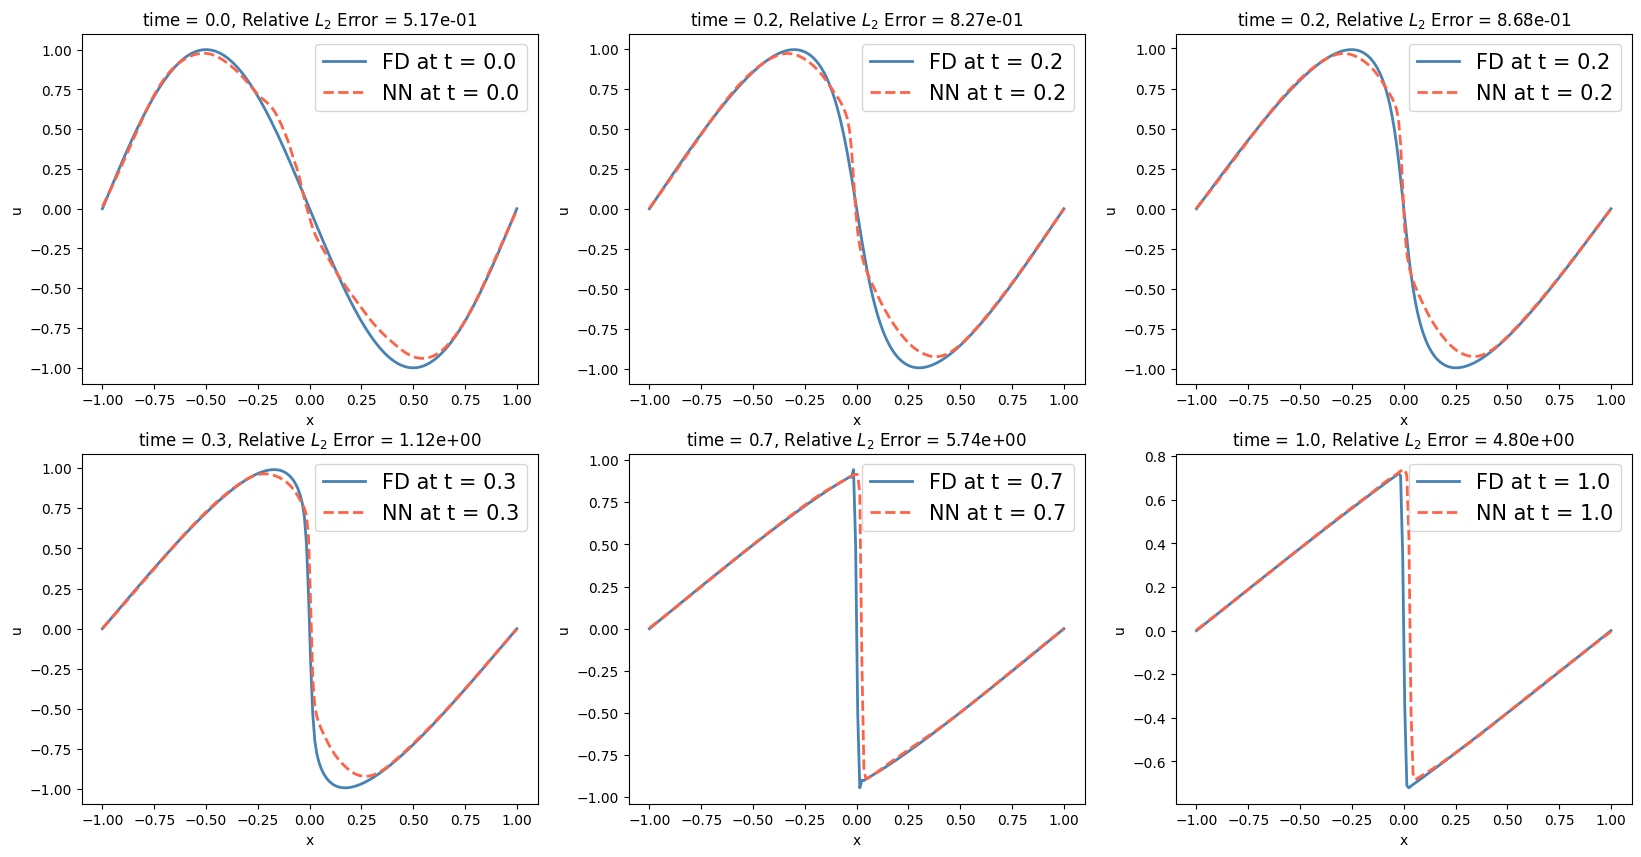

In [ ]:
with tf.device('/GPU:0'):


    dx = 0.01
    dt = 0.0001
    u_exact, t_axis = burgerseq1Dfinitediff(xmin,xmax,tmax,nu,dx,dt)
    # Select time points to plotting velocity vs position

    timepoints = np.array([0, tmax / 5, tmax / 4, tmax / 3, tmax / 1.5, tmax/1.01])
    timepoints_idx = timepoints / dt
    nx = 200  # Number of spatial grid points
    x_axis = np.linspace(xmin, xmax, nx)  # Position vector

    # Plot velocity vs position for 5 different time points

    fig1, ax1 = plt.subplots(2,3, figsize=(20, 10))
    plot_num = 0
    for i in range(0,2):
      for j in range(0,3):

        t0 = timepoints[plot_num]
        t0_axis = np.full((nx,), t0 )
        u_NN = np.squeeze(NN(tf.stack([x_axis,t0_axis], axis=1)))

        time_str = '{0:.1f}'.format(t0)

        u_exact_t0 = u_exact[:,int(timepoints_idx[plot_num])]

        ax1[i,j].plot(x_axis, u_exact_t0, color='steelblue',linewidth=2 ,label='FD at t = ' + time_str)
        ax1[i,j].plot(x_axis, u_NN , color='tomato',linewidth=2 , linestyle = '--', label='NN at t = ' + time_str )

        print('time = {0:.2f}'.format(t0))

        E = np.sum((u_NN - u_exact_t0)**2)

        relE =  np.sqrt( E / np.sum(u_exact_t0**2))
        print("Relative L2 Error = " + str("{:.2e}".format(E)) )
        ax1[i,j].title.set_text("time = {:.1f}, Relative $L_2$ Error = {:.2e}".format(t0,E))

        # Add labels
        ax1[i,j].set_xlabel('x')
        ax1[i,j].set_ylabel('u')
        ax1[i,j].legend(fontsize = 15)
        plot_num += 1

    plt.show()

## Compute the total relative eroor:


In [ ]:
x_grid,t_grid = np.meshgrid(x_axis,t_axis)
x_grid = x_grid.flatten()
t_grid = t_grid.flatten()
u =  np.squeeze(NN(tf.stack([x_grid,t_grid], axis=1)))
E =  np.sum( np.power(u - u_exact.flatten(),2) )
relE = np.sqrt( E / np.sum( np.power(u_exact.flatten(),2) ) )
print(relE)

1.3982342


## Compare the error due to a change with $\omega$, the wight for $MSE_f$

For any $t$ the absolut error define as: $$ E\left(t\right) = \max_{x} |u_{FD}\left(x,t\right) - u_{NN}\left(x,t\right)| $$



## Results

- The network successfully learns the nonlinear shock-like behavior of the solution.
- PINN predictions match well with the analytical solution.
- Visualization includes:
  - Network output surface
  - Comparison plots with the ground truth
  - Error heatmaps